<a href="https://colab.research.google.com/github/aderdouri/ql_web_app/blob/master/ql_notebooks/term_structure_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Constructing a yield curve {#yc-construction}

In this chapter we will go over the construction of treasury yield curve. Let's start by importing QuantLib and other necessary libraries.

In [ ]:
!pip install QuantLib-Python

In [1]:
import QuantLib as ql
from pandas import DataFrame
import numpy as np
import utils
%matplotlib inline

This is an example based on Exhibit 5-5 given in Frank Fabozzi's Bond Markets, Analysis and Strategies, Sixth Edition. 

In [2]:
depo_maturities = [ql.Period(6,ql.Months), ql.Period(12, ql.Months)]
depo_rates = [5.25, 5.5]

# Bond rates
bond_maturities = [ql.Period(6*i, ql.Months) for i in range(3,21)]
bond_rates = [5.75, 6.0, 6.25, 6.5, 6.75, 6.80, 7.00, 7.1, 7.15, 
              7.2, 7.3, 7.35, 7.4, 7.5, 7.6, 7.6, 7.7, 7.8]

maturities = depo_maturities+bond_maturities
rates = depo_rates+bond_rates
DataFrame(list(zip(maturities, rates)), 
          columns=["Maturities","Curve"],
          index=['']*len(rates))

,Maturities,Curve
,6M,5.25
,12M,5.50
,18M,5.75
,24M,6.00
,30M,6.25
,36M,6.50
,42M,6.75
,48M,6.80
,54M,7.00
,60M,7.10


Below we declare some constants and conventions used here. For the sake of simplicity, we assume that some of the constants are the same for deposit rates and bond rates.

In [3]:
calc_date = ql.Date(15, 1, 2015)
ql.Settings.instance().evaluationDate = calc_date

calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
business_convention = ql.Unadjusted 
day_count = ql.Thirty360(ql.Thirty360.BondBasis)
end_of_month = True
settlement_days = 0
face_amount = 100
coupon_frequency = ql.Period(ql.Semiannual)
settlement_days = 0

The basic idea of bootstrapping is to use the deposit rates and bond rates to create individual rate helpers. Then use the combination of the two helpers to construct the yield curve. As a first step, we create the deposit rate helpers as shown below.

In [4]:
depo_helpers = [
    ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r/100.0)),
                         m,
                         settlement_days,
                         calendar,
                         business_convention,
                         end_of_month,
                         day_count)
    for r, m in zip(depo_rates, depo_maturities)
]

The rest of the points are coupon bonds. We assume that the YTM given for the bonds are all par rates. So we have bonds with coupon rate same as the YTM. Using this information, we construct the fixed rate bond helpers below.

In [5]:
bond_helpers = []
for r, m in zip(bond_rates, bond_maturities):
    termination_date = calc_date + m
    schedule = ql.Schedule(calc_date,
                           termination_date, 
                           coupon_frequency, 
                           calendar,
                           business_convention, 
                           business_convention, 
                           ql.DateGeneration.Backward, 
                           end_of_month)
    
    bond_helper = ql.FixedRateBondHelper(
        ql.QuoteHandle(ql.SimpleQuote(face_amount)),
        settlement_days,
        face_amount,
        schedule,
        [r/100.0],
        day_count,
        business_convention)
    bond_helpers.append(bond_helper)

The union of the two helpers is what we use in bootstrapping shown below.

In [6]:
rate_helpers = depo_helpers + bond_helpers

The `get_spot_rates` is a convenient wrapper function that we will use to get the spot rates on a monthly interval.

In [7]:
def get_spot_rates(
        yieldcurve, day_count, 
        calendar=ql.UnitedStates(ql.UnitedStates.GovernmentBond),
        months=121
):
    spots = []
    tenors = []
    ref_date = yieldcurve.referenceDate()
    calc_date = ref_date
    for month in range(0, months):
        yrs = month/12.0
        d = calendar.advance(ref_date, ql.Period(month, ql.Months))
        compounding = ql.Compounded
        freq = ql.Semiannual
        zero_rate = yieldcurve.zeroRate(yrs, compounding, freq)
        tenors.append(yrs)
        eq_rate = zero_rate.equivalentRate(
            day_count,compounding,freq,calc_date,d).rate()
        spots.append(100*eq_rate)
    return DataFrame(list(zip(tenors, spots)),
                     columns=["Maturities","Curve"],
                     index=['']*len(tenors))

The bootstrapping process is fairly generic in QuantLib. You can chose what variable you are bootstrapping, and what is the interpolation method used in the bootstrapping. There are multiple piecewise interpolation methods that can be used for this process. The `PiecewiseLogCubicDiscount` will construct a piece wise yield curve using `LogCubic` interpolation of the `Discount` factor. Similarly `PiecewiseLinearZero` will use `Linear` interpolation of `Zero` rates. `PiecewiseCubicZero` will interpolate the `Zero` rates using a `Cubic` interpolation method.

In [8]:
yc_logcubicdiscount = ql.PiecewiseLogCubicDiscount(calc_date,
                                                   rate_helpers,
                                                   day_count)

The zero rates from the tail end of the `PiecewiseLogCubicDiscount` bootstrapping is shown below.

In [9]:
splcd = get_spot_rates(yc_logcubicdiscount, day_count)
splcd.tail()

,Maturities,Curve
,9.666667,7.981384
,9.750000,8.005292
,9.833333,8.028145
,9.916667,8.050187
,10.000000,8.071649


The yield curves using the `PiecewiseLinearZero` and `PiecewiseCubicZero` is shown below. The tail end of the zero rates obtained from `PiecewiseLinearZero` bootstrapping is also shown below. The numbers can be compared with that of the `PiecewiseLogCubicDiscount` shown above.

In [10]:
yc_linearzero = ql.PiecewiseLinearZero(
    calc_date,rate_helpers,day_count
)
yc_cubiczero = ql.PiecewiseCubicZero(
    calc_date,rate_helpers,day_count
)

splz = get_spot_rates(yc_linearzero, day_count)
spcz = get_spot_rates(yc_cubiczero, day_count)
splz.tail()

,Maturities,Curve
,9.666667,7.976804
,9.750000,8.000511
,9.833333,8.024221
,9.916667,8.047934
,10.000000,8.071649


All three are plotted below to give you an overall perspective of the three methods.

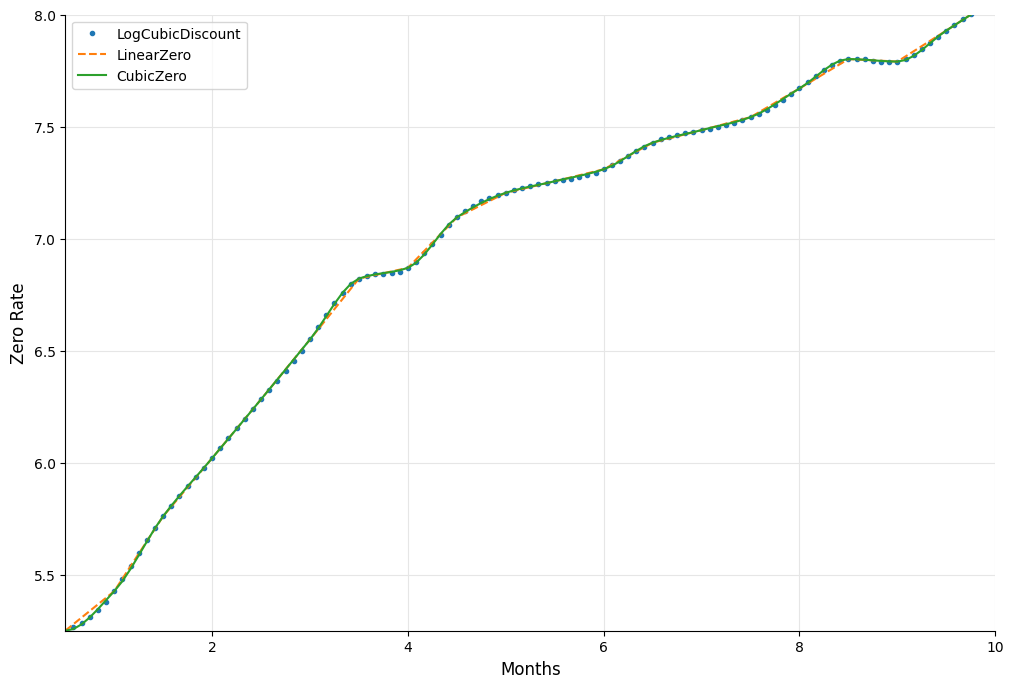

In [11]:
fig, ax = utils.plot()
ax.plot(splcd["Maturities"],splcd["Curve"], '.',
        label="LogCubicDiscount")
ax.plot(splz["Maturities"],splz["Curve"],'--', 
        label="LinearZero")
ax.plot(spcz["Maturities"],spcz["Curve"],
        label="CubicZero")
ax.set_xlabel("Months", size=12)
ax.set_ylabel("Zero Rate", size=12)
ax.set_xlim(0.5,10)
ax.set_ylim([5.25,8])
ax.legend(loc=0);

#### Conclusion
In this chapter we saw how to construct yield curves by bootstrapping bond quotes.